This kernel will implement classical image techniques and will hopefully serve as a useful primer to people who have never worked with image data before. Ultimately, we will develop a simple pipeline using `scipy` and `numpy` (and a little bit of `scikit-image`) that we can apply to the test images -- in fact, we won't even use the training images except to optimize parameters.

I'll keep updating this notebook to try and improve it - user Gabro Vecsei takes a similar approach and scores 0.22 in [this kernel]((https://www.kaggle.com/gaborvecsei/basic-pure-computer-vision-segmentation-lb-0-229). My main intention here, though, is to help out people who are new to analyses, not to score highly. 

In [59]:
import pathlib
import imageio
import numpy as np

# Glob the training data and load a single image path
training_paths = pathlib.Path('../input/stage1_train').glob('*/images/*.png')
training_sorted = sorted([x for x in training_paths])
im_path = training_sorted[0]
im = imageio.imread(str(im_path))
im_path
training_sorted

[PosixPath('../input/stage1_train/00071198d059ba7f5914a526d124d28e6d010c92466da21d4a04cd5413362552/images/00071198d059ba7f5914a526d124d28e6d010c92466da21d4a04cd5413362552.png'),
 PosixPath('../input/stage1_train/003cee89357d9fe13516167fd67b609a164651b21934585648c740d2c3d86dc1/images/003cee89357d9fe13516167fd67b609a164651b21934585648c740d2c3d86dc1.png'),
 PosixPath('../input/stage1_train/00ae65c1c6631ae6f2be1a449902976e6eb8483bf6b0740d00530220832c6d3e/images/00ae65c1c6631ae6f2be1a449902976e6eb8483bf6b0740d00530220832c6d3e.png'),
 PosixPath('../input/stage1_train/0121d6759c5adb290c8e828fc882f37dfaf3663ec885c663859948c154a443ed/images/0121d6759c5adb290c8e828fc882f37dfaf3663ec885c663859948c154a443ed.png'),
 PosixPath('../input/stage1_train/01d44a26f6680c42ba94c9bc6339228579a95d0e2695b149b7cc0c9592b21baf/images/01d44a26f6680c42ba94c9bc6339228579a95d0e2695b149b7cc0c9592b21baf.png'),
 PosixPath('../input/stage1_train/0280fa8f60f6bcae0f97d93c28f60be194f9309ff610dc5845e60455b0f87c21/images/0280

In [56]:
testing_paths = pathlib.Path('../input/stage1_test/').glob('*/images/*.png')
testing_sorted = sorted([x for x in testing_paths])
len(testing_sorted)

65

# Dealing with color

The images in this dataset can be in RGB, RGBA and grayscale format, based on the "modality" in which they are acquired. For color images, there is a third dimension which encodes the "channel" (e.g. Red, Green, Blue). To make things simpler for this first pass, we can coerce all these images into grayscale using the `rgb2gray` function from `scikit-image`.

In [60]:
# Print the image dimensions
print('Original image shape: {}'.format(im.shape))

# Coerce the image into grayscale format (if not already)
from skimage.color import rgb2gray
im_gray = rgb2gray(im)
print('New image shape: {}'.format(im_gray.shape))

Original image shape: (256, 256, 4)
New image shape: (256, 256)


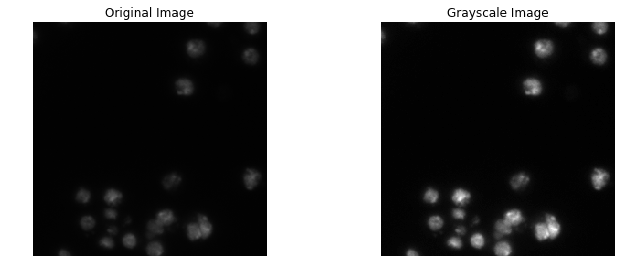

In [61]:
# Now, let's plot the data
import matplotlib.pyplot as plt

plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.imshow(im)
plt.axis('off')
plt.title('Original Image')

plt.subplot(1,2,2)
plt.imshow(im_gray, cmap='gray')
plt.axis('off')
plt.title('Grayscale Image')

plt.tight_layout()
plt.show()

# Removing background
Perhaps the simplest approach for this problem is to assume that there are two classes in the image: objects of interest and the background. Under this assumption, we would expect the data to fall into a bimodal distribution of intensities. If we found the best separation value, we could "mask" out the background data, then simply count the objects we're left with.

The "dumbest" way we could find the threshold value would be to use a simple descriptive statistic, such as the mean or median. But there are other methods: the "Otsu" method is useful because it models the image as a bimodal distribution and finds the optimal separation value. 

In [63]:
from skimage.filters import threshold_otsu
thresh_val = threshold_otsu(im_gray)
mask = np.where(im_gray > thresh_val, 1, 0)
print(mask.shape)
# Make sure the larger portion of the mask is considered background
if np.sum(mask==0) < np.sum(mask==1):
    mask = np.where(mask, 0, 1)
im_gray
print(thresh_val)
mask

(256, 256)
0.0948912377451


array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [52]:
a=np.array([0,0,0,1,1,1,1])
a=np.where(a,0,1)
a

array([1, 1, 1, 0, 0, 0, 0])

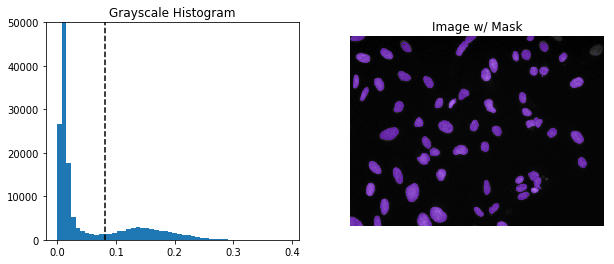

In [6]:
plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
im_pixels = im_gray.flatten()
plt.hist(im_pixels,bins=50)
plt.vlines(thresh_val, 0, 100000, linestyle='--')
plt.ylim([0,50000])
plt.title('Grayscale Histogram')

plt.subplot(1,2,2)
mask_for_display = np.where(mask, mask, np.nan)
plt.imshow(im_gray, cmap='gray')
plt.imshow(mask_for_display, cmap='rainbow', alpha=0.5)
plt.axis('off')
plt.title('Image w/ Mask')

plt.show()

# Deriving individual masks for each object

For this contest, we need to get a separate mask for each nucleus. One way we can do this is by looking for all objects in the mask that are connected, and assign each of them a number using `ndimage.label`.  Then, we can loop through each `label_id` and add it to an iterable, such as a list.

In [64]:
from scipy import ndimage
labels, nlabels = ndimage.label(mask)

label_arrays = []
for label_num in range(1, nlabels+1):
    label_mask = np.where(labels == label_num, 1, 0)
    label_arrays.append(label_mask)

print('There are {} separate components / objects detected.'.format(nlabels))

# print(mask)
# print(label_mask)
label_arrays

There are 21 separate components / objects detected.


[array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ..., 
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]]), array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ..., 
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]]), array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ..., 
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]]), array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ..., 
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]]), array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ..., 
        [0, 0, 0, ..., 0, 0, 0],
  

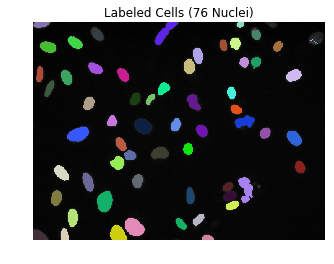

In [7]:
# Create a random colormap
from matplotlib.colors import ListedColormap
rand_cmap = ListedColormap(np.random.rand(256,3))

labels_for_display = np.where(labels > 0, labels, np.nan)
plt.imshow(im_gray, cmap='gray')
plt.imshow(labels_for_display, cmap=rand_cmap)
plt.axis('off')
plt.title('Labeled Cells ({} Nuclei)'.format(nlabels))
plt.show()

A quick glance reveals two problems (in this very simple image): 

- There are a few individual pixels that stand alone (e.g. top-right)
- Some cells are combined into a single mask (e.g., top-middle)
    
Using `ndimage.find_objects`, we can iterate through our masks, zooming in on the individual nuclei found to apply additional processing steps.  `find_objects` returns a list of the coordinate range for each labeled object in your image.

In [9]:
for label_ind, label_coords in enumerate(ndimage.find_objects(labels)):
    cell = im_gray[label_coords]
    
    # Check if the label size is too small
    if np.product(cell.shape) < 10: 
        print('Label {} is too small! Setting to 0.'.format(label_ind))
        mask = np.where(labels==label_ind+1, 0, mask)

# Regenerate the labels
labels, nlabels = ndimage.label(mask)
print('There are now {} separate components / objects detected.'.format(nlabels))

Label 4 is too small! Setting to 0.
Label 5 is too small! Setting to 0.
Label 7 is too small! Setting to 0.
Label 8 is too small! Setting to 0.
Label 9 is too small! Setting to 0.
Label 10 is too small! Setting to 0.
Label 14 is too small! Setting to 0.
Label 15 is too small! Setting to 0.
Label 16 is too small! Setting to 0.
Label 19 is too small! Setting to 0.
Label 21 is too small! Setting to 0.
Label 22 is too small! Setting to 0.
Label 23 is too small! Setting to 0.
Label 60 is too small! Setting to 0.
Label 61 is too small! Setting to 0.
Label 72 is too small! Setting to 0.
There are now 60 separate components / objects detected.


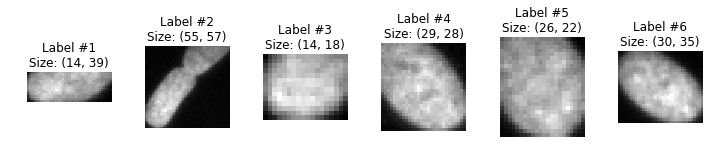

In [10]:
fig, axes = plt.subplots(1,6, figsize=(10,6))

for ii, obj_indices in enumerate(ndimage.find_objects(labels)[0:6]):
    cell = im_gray[obj_indices]
    axes[ii].imshow(cell, cmap='gray')
    axes[ii].axis('off')
    axes[ii].set_title('Label #{}\nSize: {}'.format(ii+1, cell.shape))

plt.tight_layout()
plt.show()

Label #2 has the "adjacent cell" problem: the two cells are being considered part of the same object. One thing we can do here is to see whether we can shrink the mask to "open up" the differences between the cells. This is called mask erosion. We can then re-dilate it to to recover the original proportions. 

In [11]:
# Get the object indices, and perform a binary opening procedure
two_cell_indices = ndimage.find_objects(labels)[1]
cell_mask = mask[two_cell_indices]
cell_mask_opened = ndimage.binary_opening(cell_mask, iterations=8)

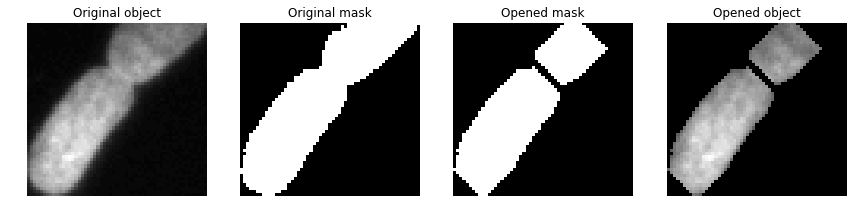

In [12]:
fig, axes = plt.subplots(1,4, figsize=(12,4))

axes[0].imshow(im_gray[two_cell_indices], cmap='gray')
axes[0].set_title('Original object')
axes[1].imshow(mask[two_cell_indices], cmap='gray')
axes[1].set_title('Original mask')
axes[2].imshow(cell_mask_opened, cmap='gray')
axes[2].set_title('Opened mask')
axes[3].imshow(im_gray[two_cell_indices]*cell_mask_opened, cmap='gray')
axes[3].set_title('Opened object')


for ax in axes:
    ax.axis('off')
plt.tight_layout()
plt.show()

# Convert each labeled object to Run Line Encoding
Finally, we need to encode each `label_mask` into a "run line encoded" string. Basically, we walk through the array, and when we find a pixel that is part of the mask, we index it and count how many subsequent pixels are also part of the mask. We repeat this each time we see new pixel start point.

I found a nice function to do RLE from [Kaggle user Rakhlin's kernel](https://www.kaggle.com/rakhlin/fast-run-length-encoding-python), which I've copied here.

In [23]:
def rle_encoding(x):
    '''
    x: numpy array of shape (height, width), 1 - mask, 0 - background
    Returns run length as list
    '''
    dots = np.where(x.T.flatten()==1)[0] # .T sets Fortran order down-then-right
    run_lengths = []
    prev = -2
    for b in dots:
        if (b>prev+1): run_lengths.extend((b+1, 0))
        run_lengths[-1] += 1
        prev = b
    return " ".join([str(i) for i in run_lengths])

print('RLE Encoding for the current mask is: {}'.format(rle_encoding(label_mask)))
label_mask.T.flatten()[210074:210080]

RLE Encoding for the current mask is: 210075 6 210593 8 211112 9 211631 10 212150 11 212669 12 213189 12 213709 12 214228 13 214748 13 215268 13 215788 13 216308 13 216828 13 217348 13 217869 12 218389 12 218909 12 219430 11 219950 11 220471 10 220991 10 221512 9 222033 8 222554 7 223075 6 223596 5 224117 4 224639 2


array([1, 1, 1, 1, 1, 1])

In [21]:
def zero_count(x):
    k=0
    for i in range(x.shape[0]):
        for j in range(x.shape[1]):
            if x[i][j]==0:
                k+=1
    return k

print(zero_count(label_mask))

d=label_mask.shape

d[0]*d[1]-zero_count(label_mask)
6+8+9+10+11+12+12+12+13+13+13+13+13+13+13+12+12+12+11+11+10+10+9+8+7+6+5+4+2

361630


290

# Combine it into a single function
Now that we've seen the basic steps to processing an image in a "dumb" way, we can combine it all into a single function. This function will take an image path, perform the processes outlined above, and spit out a dataframe with the RLE strings for each mask found. 

We also create a wrapper function that will spit out a single DataFrame for all images in the dataset.

In [9]:
import pandas as pd

def analyze_image(im_path):
    '''
    Take an image_path (pathlib.Path object), preprocess and label it, extract the RLE strings 
    and dump it into a Pandas DataFrame.
    '''
    # Read in data and convert to grayscale
    im_id = im_path.parts[-3]
    im = imageio.imread(str(im_path))
    im_gray = rgb2gray(im)
    
    # Mask out background and extract connected objects
    thresh_val = threshold_otsu(im_gray)
    mask = np.where(im_gray > thresh_val, 1, 0)
    if np.sum(mask==0) < np.sum(mask==1):
        mask = np.where(mask, 0, 1)    
        labels, nlabels = ndimage.label(mask)
    labels, nlabels = ndimage.label(mask)
    
    # Loop through labels and add each to a DataFrame
    im_df = pd.DataFrame()
    for label_num in range(1, nlabels+1):
        label_mask = np.where(labels == label_num, 1, 0)
        if label_mask.flatten().sum() > 10:
            rle = rle_encoding(label_mask)
            s = pd.Series({'ImageId': im_id, 'EncodedPixels': rle})
            im_df = im_df.append(s, ignore_index=True)
    
    return im_df


def analyze_list_of_images(im_path_list):
    '''
    Takes a list of image paths (pathlib.Path objects), analyzes each,
    and returns a submission-ready DataFrame.'''
    all_df = pd.DataFrame()
    for im_path in im_path_list:
        im_df = analyze_image(im_path)
        all_df = all_df.append(im_df, ignore_index=True)
    
    return all_df

In [57]:
testing = pathlib.Path('../input/stage1_test/').glob('*/images/*.png')
df = analyze_list_of_images(list(testing))
df.to_csv('submission.csv', index=None)

In [25]:
list(testing)

[]

In [58]:
df

,EncodedPixels,ImageId
0,15366 1 15619 4 15874 6 16130 5 16385 4 16641 ...,912a679e4b9b1d1a75170254fd675b8c24b664d80ad7ea...
1,37889 1 37891 2 38145 5 38401 5 38657 6 38913 ...,912a679e4b9b1d1a75170254fd675b8c24b664d80ad7ea...
2,61186 2 61441 3 61697 6 61953 6 62209 6 62465 ...,912a679e4b9b1d1a75170254fd675b8c24b664d80ad7ea...
3,8201 2 8454 9 8710 10 8965 12 9221 12 9477 12 ...,912a679e4b9b1d1a75170254fd675b8c24b664d80ad7ea...
4,27916 1 27918 2 28172 7 28427 9 28682 11 28938...,912a679e4b9b1d1a75170254fd675b8c24b664d80ad7ea...
5,50446 5 50701 7 50957 8 51212 9 51469 9 51724 ...,912a679e4b9b1d1a75170254fd675b8c24b664d80ad7ea...
6,34834 6 35089 8 35344 10 35598 13 35853 14 361...,912a679e4b9b1d1a75170254fd675b8c24b664d80ad7ea...
7,56855 6 57109 9 57364 10 57620 10 57875 11 581...,912a679e4b9b1d1a75170254fd675b8c24b664d80ad7ea...
8,61464 2 61719 4 61973 7 62228 10 62484 9 62740...,912a679e4b9b1d1a75170254fd675b8c24b664d80ad7ea...
9,18715 7 18969 10 19224 12 19480 12 19735 13 19...,912a679e4b9b1d1a75170254fd675b8c24b664d80ad7ea...
